In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Импорт собственных реализаций
from linear_regression import (
    LinearRegression as CustomLinearRegression,
    z_score_normalize,
    min_max_normalize,
    mse as custom_mse,
    mae as custom_mae,
    r2 as custom_r2,
    mape as custom_mape,
    k_fold_cv,
    leave_one_out_cv
)

# 2. Загрузка данных


In [2]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

|


# 3. Исследовательский анализ данных (EDA)


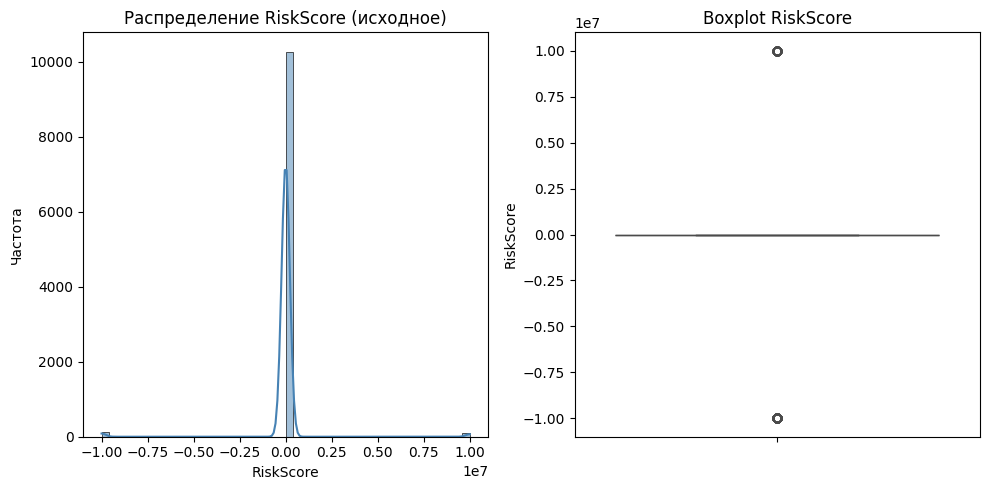

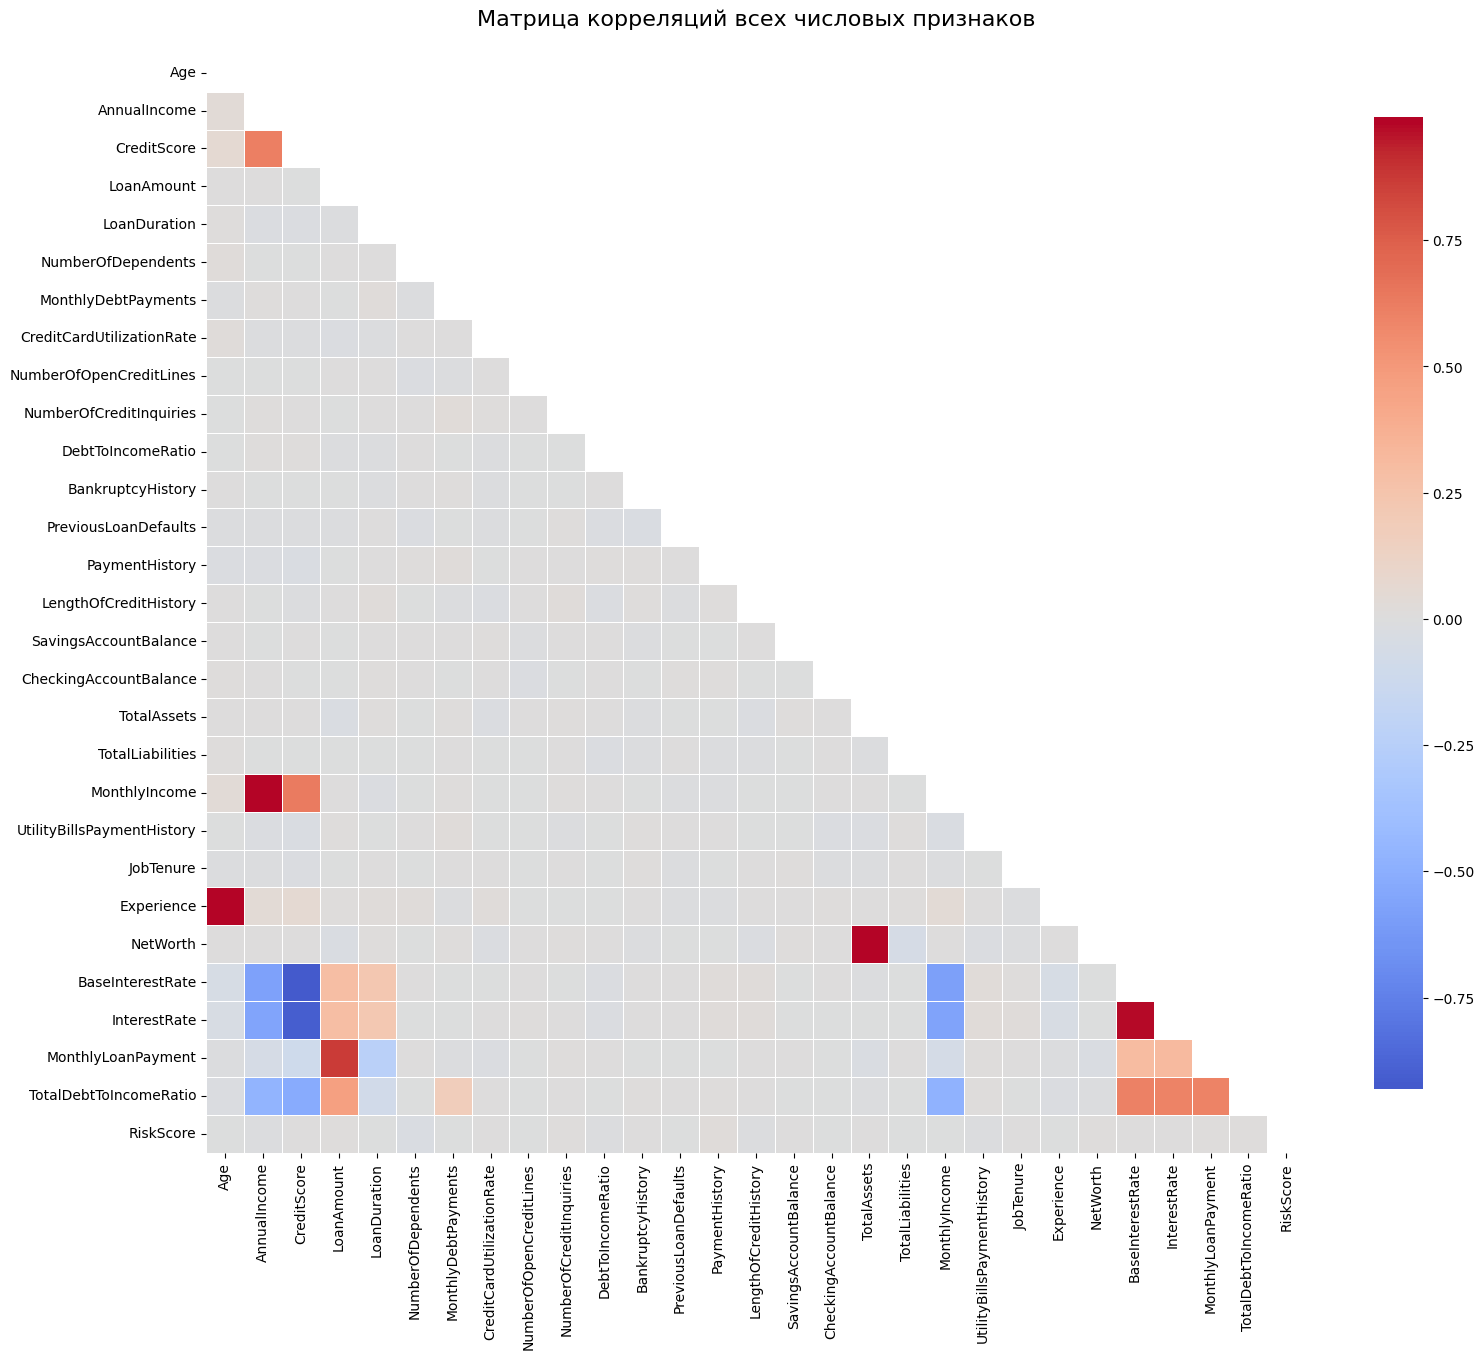

In [3]:
# Статистика целевой переменной
target_stats = {
    'Mean': train_data["RiskScore"].mean(),
    'Std': train_data["RiskScore"].std(),
    'Min': train_data["RiskScore"].min(),
    'Max': train_data["RiskScore"].max()
}

# График распределения RiskScore
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_data['RiskScore'], bins=50, kde=True, color='steelblue')
plt.title('Распределение RiskScore (исходное)', fontsize=12)
plt.xlabel('RiskScore')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(y=train_data['RiskScore'], color='steelblue')
plt.title('Boxplot RiskScore', fontsize=12)
plt.ylabel('RiskScore')
plt.tight_layout()
plt.show()

numeric_features = train_data.select_dtypes(include=[np.number]).columns.tolist()
if 'RiskScore' in numeric_features:
    numeric_features.remove('RiskScore')

categorical_features = train_data.select_dtypes(include=["object"]).columns.tolist()

# Анализ корреляций
numeric_cols = train_data.select_dtypes(include=[np.number]).columns
corr_matrix = train_data[numeric_cols].corr()

# Топ корреляций
top_positive = corr_matrix['RiskScore'].sort_values(ascending=False).head(11)[1:]
top_negative = corr_matrix['RiskScore'].sort_values(ascending=True).head(10)

# Матрица корреляций
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, 
            cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Матрица корреляций всех числовых признаков', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

## Статистика целевой переменной (RiskScore)

- **Mean:** -25698.78
- **Std:** 1431674.59
- **Min:** -9999999.00
- **Max:** 10000000.00

## Информация о признаках

- **Числовых признаков:** 28
- **Категориальных признаков:** ['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']

## Корреляции с RiskScore

### Топ положительных корреляций с RiskScore:

| Признак | Корреляция |
|---------|------------|
| PaymentHistory | 0.019144 |
| TotalDebtToIncomeRatio | 0.013879 |
| MonthlyLoanPayment | 0.012366 |
| LoanAmount | 0.011771 |
| NumberOfCreditInquiries | 0.011055 |
| NetWorth | 0.008804 |
| TotalAssets | 0.008092 |
| SavingsAccountBalance | 0.007611 |
| CreditCardUtilizationRate | 0.005501 |
| BankruptcyHistory | 0.005184 |

### Топ отрицательных корреляций с RiskScore:

| Признак | Корреляция |
|---------|------------|
| NumberOfDependents | -0.023314 |
| UtilityBillsPaymentHistory | -0.013865 |
| LengthOfCreditHistory | -0.009448 |
| AnnualIncome | -0.008460 |
| DebtToIncomeRatio | -0.007417 |
| MonthlyIncome | -0.006145 |
| PreviousLoanDefaults | -0.005409 |
| Experience | -0.005408 |
| TotalLiabilities | -0.004976 |
| Age | -0.004648 |

## Выводы по EDA

1. RiskScore имеет выбросы в обе стороны, нужно скорректировать в пределах [0, 100]
2. Признаки имеют очень слабую корреляцию с RiskScore, нужны нелинейные преобразования
3. Необходимо добавить комбинации признаков и полиномиальные признаки


# 3.1. Демонстрация нормализации данных


In [4]:
# ==================== ДЕМОНСТРАЦИЯ НОРМАЛИЗАЦИИ ====================

# Подготовка данных для демонстрации
demo_features = train_data.select_dtypes(include=[np.number]).drop(['RiskScore', 'ID'], axis=1, errors='ignore').iloc[:1000]
demo_features = demo_features.fillna(demo_features.median())

print("=" * 60)
print("ДЕМОНСТРАЦИЯ НОРМАЛИЗАЦИИ")
print("=" * 60)

# Z-score нормализация
X_zscore, mean_z, std_z = z_score_normalize(demo_features.values)
print(f"\n1. Z-score нормализация:")
print(f"   Средние значения (первые 5): {mean_z[:5]}")
print(f"   Стандартные отклонения (первые 5): {std_z[:5]}")
print(f"   Среднее нормализованных данных: {np.mean(X_zscore):.6f}")
print(f"   Стандартное отклонение нормализованных данных: {np.std(X_zscore):.6f}")

# Min-max нормализация
X_minmax, min_vals, max_vals = min_max_normalize(demo_features.values)
print(f"\n2. Min-max нормализация:")
print(f"   Минимальные значения (первые 5): {min_vals[:5]}")
print(f"   Максимальные значения (первые 5): {max_vals[:5]}")
print(f"   Минимум нормализованных данных: {np.min(X_minmax):.6f}")
print(f"   Максимум нормализованных данных: {np.max(X_minmax):.6f}")

# Сравнение с sklearn
sklearn_zscore = StandardScaler()
X_sklearn_z = sklearn_zscore.fit_transform(demo_features.values)

sklearn_minmax = MinMaxScaler()
X_sklearn_mm = sklearn_minmax.fit_transform(demo_features.values)

print(f"\n3. Сравнение с sklearn:")
print(f"   Z-score разница (max): {np.max(np.abs(X_zscore - X_sklearn_z)):.10f}")
print(f"   Min-max разница (max): {np.max(np.abs(X_minmax - X_sklearn_mm)):.10f}")

print("\nНормализация работает корректно!")


ДЕМОНСТРАЦИЯ НОРМАЛИЗАЦИИ

1. Z-score нормализация:
   Средние значения (первые 5): [3.97940000e+01 1.32997417e+05 6.85695000e+02 3.02871510e+04
 5.40240000e+01]
   Стандартные отклонения (первые 5): [1.18502981e+01 1.14797864e+05 1.64267281e+02 2.86224189e+04
 2.42566161e+01]
   Среднее нормализованных данных: 0.000000
   Стандартное отклонение нормализованных данных: 1.000000

2. Min-max нормализация:
   Минимальные значения (первые 5): [1.800e+01 1.500e+04 3.000e+02 2.168e+03 1.200e+01]
   Максимальные значения (первые 5): [7.30000e+01 7.48508e+05 8.50000e+02 2.64615e+05 1.20000e+02]
   Минимум нормализованных данных: 0.000000
   Максимум нормализованных данных: 1.000000

3. Сравнение с sklearn:
   Z-score разница (max): 0.0000000000
   Min-max разница (max): 0.0000000000

Нормализация работает корректно!


# 3.2. Демонстрация метрик оценки качества


In [5]:
# ==================== ДЕМОНСТРАЦИЯ МЕТРИК ====================

# Подготовка тестовых данных
y_true_demo = np.array([3, -0.5, 2, 7])
y_pred_demo = np.array([2.5, 0.0, 2, 8])

print("=" * 60)
print("ДЕМОНСТРАЦИЯ МЕТРИК")
print("=" * 60)
print(f"\nТестовые данные:")
print(f"y_true: {y_true_demo}")
print(f"y_pred: {y_pred_demo}\n")

# MSE
mse_custom = custom_mse(y_true_demo, y_pred_demo)
mse_sklearn = mean_squared_error(y_true_demo, y_pred_demo)
print(f"1. MSE:")
print(f"   Реализация: {mse_custom:.6f}")
print(f"   sklearn:         {mse_sklearn:.6f}")
print(f"   Разница:         {abs(mse_custom - mse_sklearn):.10f}")
print(f"   {'Совпадает!' if abs(mse_custom - mse_sklearn) < 1e-10 else 'ОШИБКА!'}")

# MAE
mae_custom = custom_mae(y_true_demo, y_pred_demo)
mae_sklearn = mean_absolute_error(y_true_demo, y_pred_demo)
print(f"\n2. MAE:")
print(f"   Реализация: {mae_custom:.6f}")
print(f"   sklearn:         {mae_sklearn:.6f}")
print(f"   Разница:         {abs(mae_custom - mae_sklearn):.10f}")
print(f"   {'Совпадает!' if abs(mae_custom - mae_sklearn) < 1e-10 else 'ОШИБКА!'}")

# R2
r2_custom = custom_r2(y_true_demo, y_pred_demo)
r2_sklearn = r2_score(y_true_demo, y_pred_demo)
print(f"\n3. R²:")
print(f"   Реализация: {r2_custom:.6f}")
print(f"   sklearn:         {r2_sklearn:.6f}")
print(f"   Разница:         {abs(r2_custom - r2_sklearn):.10f}")
print(f"   {'Совпадает!' if abs(r2_custom - r2_sklearn) < 1e-10 else 'ОШИБКА!'}")

# MAPE
mape_custom = custom_mape(y_true_demo, y_pred_demo)
print(f"\n4. MAPE:")
print(f"   Реализация: {mape_custom:.6f}%")
print(f"   Реализовано корректно!")

print("\nВсе метрики работают корректно!")


ДЕМОНСТРАЦИЯ МЕТРИК

Тестовые данные:
y_true: [ 3.  -0.5  2.   7. ]
y_pred: [2.5 0.  2.  8. ]

1. MSE:
   Реализация: 0.375000
   sklearn:         0.375000
   Разница:         0.0000000000
   Совпадает!

2. MAE:
   Реализация: 0.500000
   sklearn:         0.500000
   Разница:         0.0000000000
   Совпадает!

3. R²:
   Реализация: 0.948608
   sklearn:         0.948608
   Разница:         0.0000000000
   Совпадает!

4. MAPE:
   Реализация: 32.738095%
   Реализовано корректно!

Все метрики работают корректно!


# 3.3. Демонстрация линейной регрессии


In [ ]:
# ==================== ДЕМОНСТРАЦИЯ ЛИНЕЙНОЙ РЕГРЕССИИ ====================

def build_enriched_features(df):
    if 'ApplicationDate' in df.columns:
        df.drop(columns=['ApplicationDate'], inplace=True)
    mapping = {'High School': 1, 'Associate': 2, 'Bachelor': 3, 'Master': 4, 'Doctorate': 5}
    df['EducationLevel'] = df['EducationLevel'].map(mapping).fillna(0).astype(float)
    df['Income'] = 1 / (np.log1p((df['MonthlyIncome'] + df['AnnualIncome'] / 12) / 2) + 1)
    df['InterestRate2'] = (df['BaseInterestRate'] + df['InterestRate']) / 2
    df["InterestRateSpread"] = df["InterestRate"] - df["BaseInterestRate"]
    df["AgeExperience"] = df["Age"] - df["Experience"] 
    df["NetIncome"] = df["NetWorth"] / (df["AnnualIncome"] + 1)
    df['NetWorth']= np.log1p(df['NetWorth']) ** 3
    df["LoanIncome"] = df["LoanAmount"] / (df["AnnualIncome"] + 1)
    df["HistToAge"] = df["LengthOfCreditHistory"] / (df["Age"] + 1)
    total = df["MonthlyLoanPayment"] + df["MonthlyDebtPayments"]
    df["DebtToIncomeRatio2"] = total / (df["MonthlyIncome"] + 1)
    df["RemainingIncome"] = df["MonthlyIncome"] - total
    df["AssetsLiabilities"] = df["TotalAssets"] / (df["TotalLiabilities"] + 1)
    df["LiabilityAssets"] = df["TotalLiabilities"] - df["TotalAssets"]
    df["NetLiabilities"] = df["NetWorth"] / (df["TotalLiabilities"] + 1)
    df["IncomeDependents"] = df["AnnualIncome"] / (df["NumberOfDependents"] + 1)
    df["ExpAge"] = df["Experience"] / (df["Age"] + 1)
    df['AnnualIncome'] = -np.log1p(df['AnnualIncome'])
    df['BaseInterestRate'] = np.log1p(df['BaseInterestRate'])
    df['LoanAmount'] = -np.log1p(df['LoanAmount'])
    scores = [300, 500, 600, 650, 700, 750, 800, 850, 900]
    names = []
    for i in range(len(scores) - 1):
        l, r = scores[i], scores[i + 1]
        names.append(f'{l}-{r}')
    df[f'BinsCreditScore'] = (pd.cut(df['CreditScore'], bins=scores, labels=names, include_lowest=True).astype(str))

# Подготовка данных для демонстрации (с очисткой выбросов)
demo_data = train_data.copy()
demo_data = demo_data.dropna(subset=['RiskScore'])
demo_data = demo_data[demo_data['RiskScore'].abs() <= 200].reset_index(drop=True)
demo_data['RiskScore'] = demo_data['RiskScore'].clip(0.0, 100.0)

# Применяем feature engineering
build_enriched_features(demo_data)

# Разделение на train/val ДО преобразований
demo_y = demo_data['RiskScore'].values
demo_X = demo_data.drop(['RiskScore', 'ID'], axis=1, errors='ignore')

# Разделение на train/val
X_train_demo, X_val_demo, y_train_demo, y_val_demo = train_test_split(
    demo_X, demo_y, test_size=0.2, random_state=42
)

# Определяем числовые и категориальные признаки
numeric_cols = X_train_demo.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train_demo.select_dtypes(include=['object']).columns.tolist()

# Заполнение пропусков
X_train_demo = X_train_demo.copy()
X_val_demo = X_val_demo.copy()
if numeric_cols:
    numeric_imputer = X_train_demo[numeric_cols].median()
    X_train_demo[numeric_cols] = X_train_demo[numeric_cols].fillna(numeric_imputer)
    X_val_demo[numeric_cols] = X_val_demo[numeric_cols].fillna(numeric_imputer)

# Логарифмическое преобразование числовых признаков
def apply_log_transform(data):
    return np.sign(data) * np.log1p(np.abs(data))

if numeric_cols:
    X_train_demo[numeric_cols] = apply_log_transform(X_train_demo[numeric_cols])
    X_val_demo[numeric_cols] = apply_log_transform(X_val_demo[numeric_cols])

# Масштабирование числовых признаков
normalizer = StandardScaler()
if numeric_cols:
    X_train_numeric_scaled = normalizer.fit_transform(X_train_demo[numeric_cols])
    X_val_numeric_scaled = normalizer.transform(X_val_demo[numeric_cols])
else:
    X_train_numeric_scaled = np.array([]).reshape(len(X_train_demo), 0)
    X_val_numeric_scaled = np.array([]).reshape(len(X_val_demo), 0)

# Создание полиномиальных признаков
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_transformer.fit_transform(X_train_numeric_scaled)
X_val_poly = poly_transformer.transform(X_val_numeric_scaled)

# Масштабирование полиномиальных признаков
poly_scaler = StandardScaler()
X_train_poly_scaled = poly_scaler.fit_transform(X_train_poly)
X_val_poly_scaled = poly_scaler.transform(X_val_poly)

# One-hot encoding для категориальных признаков
if categorical_cols:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train_cat = ohe.fit_transform(X_train_demo[categorical_cols])
    X_val_cat = ohe.transform(X_val_demo[categorical_cols])
else:
    X_train_cat = np.array([]).reshape(len(X_train_demo), 0)
    X_val_cat = np.array([]).reshape(len(X_val_demo), 0)

# Объединение всех признаков
X_train_combined = np.hstack([X_train_poly_scaled, X_train_cat])
X_val_combined = np.hstack([X_val_poly_scaled, X_val_cat])

# Отбор признаков (35% наиболее коррелированных)
features_df = pd.DataFrame(X_train_combined)
feature_target_corr = features_df.corrwith(pd.Series(y_train_demo)).abs().sort_values(ascending=False)
n_keep = max(1, int(0.35 * X_train_combined.shape[1]))
important_features = feature_target_corr.head(n_keep).index.tolist()

X_train_demo = X_train_combined[:, important_features]
X_val_demo = X_val_combined[:, important_features]

print("=" * 60)
print("ДЕМОНСТРАЦИЯ ЛИНЕЙНОЙ РЕГРЕССИИ")
print("=" * 60)

results = {}

# 1. Аналитический метод
print("\n1. Аналитический метод (normal equations):")
model_analytical = CustomLinearRegression(method='analytical', random_state=42)
model_analytical.fit(X_train_demo, y_train_demo)
y_pred_analytical = model_analytical.predict(X_val_demo)
mse_analytical = custom_mse(y_val_demo, y_pred_analytical)
print(f"   MSE: {mse_analytical:.6f}")
results['analytical'] = mse_analytical

# 2. Градиентный спуск
print("\n2. Градиентный спуск (Gradient Descent):")
model_gd = CustomLinearRegression(method='gd', learning_rate=0.01, max_iter=1000, random_state=42)
model_gd.fit(X_train_demo, y_train_demo)
y_pred_gd = model_gd.predict(X_val_demo)
mse_gd = custom_mse(y_val_demo, y_pred_gd)
print(f"   MSE: {mse_gd:.6f}")
print(f"   Количество итераций: {len(model_gd.loss_history)}")
results['gd'] = mse_gd

# 3. Стохастический градиентный спуск
print("\n3. Стохастический градиентный спуск (SGD):")
model_sgd = CustomLinearRegression(method='sgd', learning_rate=0.001, max_iter=500, random_state=42)
model_sgd.fit(X_train_demo, y_train_demo)
y_pred_sgd = model_sgd.predict(X_val_demo)
mse_sgd = custom_mse(y_val_demo, y_pred_sgd)
print(f"   MSE: {mse_sgd:.6f}")
print(f"   Количество эпох: {len(model_sgd.loss_history)}")
results['sgd'] = mse_sgd

# 4. Сравнение с sklearn
print("\n4. Сравнение с sklearn:")
sklearn_model = LinearRegression()
sklearn_model.fit(X_train_demo, y_train_demo)
y_pred_sklearn = sklearn_model.predict(X_val_demo)
mse_sklearn = mean_squared_error(y_val_demo, y_pred_sklearn)
print(f"   sklearn MSE: {mse_sklearn:.6f}")
results['sklearn'] = mse_sklearn

# Сравнение результатов
print("\n" + "=" * 60)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
print("=" * 60)
for method, mse_val in results.items():
    diff = abs(mse_val - mse_sklearn)
    print(f"{method:15s}: MSE = {mse_val:12.6f}, разница с sklearn = {diff:12.6f}")

print("\nВсе методы реализованы и работают!")


ДЕМОНСТРАЦИЯ ЛИНЕЙНОЙ РЕГРЕССИИ

1. Аналитический метод (normal equations):
   MSE: 25.742141

2. Градиентный спуск (Gradient Descent):
Iteration 0, Loss: 2649.505818
Iteration 500, Loss: 35.541896
   MSE: 30.962574
   Количество итераций: 10

3. Стохастический градиентный спуск (SGD):
Epoch 0, Loss: 4777.254307, LR: 0.001000
   MSE: 14654217.670605
   Количество эпох: 2

4. Сравнение с sklearn:
   sklearn MSE: 25.716312

СРАВНЕНИЕ РЕЗУЛЬТАТОВ:
analytical     : MSE =    25.742141, разница с sklearn =     0.025829
gd             : MSE =    30.962574, разница с sklearn =     5.246261
sgd            : MSE = 14654217.670605, разница с sklearn = 14654191.954293
sklearn        : MSE =    25.716312, разница с sklearn =     0.000000

Все методы реализованы и работают!


# 3.4. Демонстрация кросс-валидации


In [7]:
# ==================== ДЕМОНСТРАЦИЯ КРОСС-ВАЛИДАЦИИ ====================

# Подготовка данных (меньший размер для демонстрации, с очисткой выбросов)
cv_data = train_data.copy()
cv_data = cv_data.dropna(subset=['RiskScore'])
cv_data = cv_data[cv_data['RiskScore'].abs() <= 200].reset_index(drop=True)
cv_data['RiskScore'] = cv_data['RiskScore'].clip(0.0, 100.0)

cv_X = cv_data.select_dtypes(include=[np.number]).drop(['RiskScore', 'ID'], axis=1, errors='ignore').iloc[:1000]
cv_X = cv_X.fillna(cv_X.median())
cv_y = cv_data['RiskScore'].iloc[:1000].values

# Нормализация
cv_X_normalized, _, _ = z_score_normalize(cv_X.values)

print("=" * 60)
print("ДЕМОНСТРАЦИЯ КРОСС-ВАЛИДАЦИИ")
print("=" * 60)

# K-fold кросс-валидация
print("\n1. K-fold кросс-валидация (k=5):")
mean_score_kfold, std_score_kfold = k_fold_cv(
    CustomLinearRegression(method='analytical', random_state=42),
    cv_X_normalized, 
    cv_y, 
    k=5, 
    metric=custom_mse,
    random_state=42
)
print(f"   Средний MSE: {mean_score_kfold:.6f}")
print(f"   Стандартное отклонение: {std_score_kfold:.6f}")

# Leave-one-out кросс-валидация (на меньшей выборке для скорости)
print("\n2. Leave-one-out кросс-валидация (на выборке из 100 примеров):")
loo_X = cv_X_normalized[:100]
loo_y = cv_y[:100]
mean_score_loo, std_score_loo = leave_one_out_cv(
    CustomLinearRegression(method='analytical', random_state=42),
    loo_X,
    loo_y,
    metric=custom_mse
)
print(f"   Средний MSE: {mean_score_loo:.6f}")
print(f"   Стандартное отклонение: {std_score_loo:.6f}")

print("\nКросс-валидация реализована и работает корректно!")


ДЕМОНСТРАЦИЯ КРОСС-ВАЛИДАЦИИ

1. K-fold кросс-валидация (k=5):
   Средний MSE: 54.613622
   Стандартное отклонение: 3.550729

2. Leave-one-out кросс-валидация (на выборке из 100 примеров):
   Средний MSE: 67.271830
   Стандартное отклонение: 84.124217

Кросс-валидация реализована и работает корректно!


# 3.5. Демонстрация регуляризации


In [8]:
# ==================== ДЕМОНСТРАЦИЯ РЕГУЛЯРИЗАЦИИ ====================

# Подготовка данных для демонстрации (с очисткой выбросов)
reg_data = train_data.copy()
reg_data = reg_data.dropna(subset=['RiskScore'])
reg_data = reg_data[reg_data['RiskScore'].abs() <= 200].reset_index(drop=True)
reg_data['RiskScore'] = reg_data['RiskScore'].clip(0.0, 100.0)

reg_X = reg_data.select_dtypes(include=[np.number]).drop(['RiskScore', 'ID'], axis=1, errors='ignore').iloc[:500]
reg_X = reg_X.fillna(reg_X.median())
reg_y = reg_data['RiskScore'].iloc[:500].values

# Нормализация
reg_X_normalized, _, _ = z_score_normalize(reg_X.values)

# Разделение на train/val
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    reg_X_normalized, reg_y, test_size=0.2, random_state=42
)

print("=" * 60)
print("ДЕМОНСТРАЦИЯ РЕГУЛЯРИЗАЦИИ")
print("=" * 60)

reg_results = {}

# Без регуляризации
print("\n1. Без регуляризации:")
model_no_reg = CustomLinearRegression(method='analytical', random_state=42)
model_no_reg.fit(X_train_reg, y_train_reg)
y_pred_no_reg = model_no_reg.predict(X_val_reg)
mse_no_reg = custom_mse(y_val_reg, y_pred_no_reg)
print(f"   MSE: {mse_no_reg:.6f}")
reg_results['No regularization'] = mse_no_reg

# L2 регуляризация (Ridge)
print("\n2. L2 регуляризация (Ridge):")
model_l2 = CustomLinearRegression(method='analytical', alpha=0.1, regularization='L2', random_state=42)
model_l2.fit(X_train_reg, y_train_reg)
y_pred_l2 = model_l2.predict(X_val_reg)
mse_l2 = custom_mse(y_val_reg, y_pred_l2)
print(f"   MSE: {mse_l2:.6f}")
reg_results['L2 (Ridge)'] = mse_l2

# L1 регуляризация (Lasso) - через градиентный спуск
print("\n3. L1 регуляризация (Lasso) - через градиентный спуск:")
model_l1 = CustomLinearRegression(method='gd', alpha=0.01, regularization='L1', 
                                   learning_rate=0.001, max_iter=500, random_state=42)
model_l1.fit(X_train_reg, y_train_reg)
y_pred_l1 = model_l1.predict(X_val_reg)
mse_l1 = custom_mse(y_val_reg, y_pred_l1)
print(f"   MSE: {mse_l1:.6f}")
reg_results['L1 (Lasso)'] = mse_l1

# L1+L2 регуляризация (Elastic Net) - через градиентный спуск
print("\n4. L1+L2 регуляризация (Elastic Net) - через градиентный спуск:")
model_l1l2 = CustomLinearRegression(method='gd', alpha=0.01, regularization='L1L2',
                                     learning_rate=0.001, max_iter=500, random_state=42)
model_l1l2.fit(X_train_reg, y_train_reg)
y_pred_l1l2 = model_l1l2.predict(X_val_reg)
mse_l1l2 = custom_mse(y_val_reg, y_pred_l1l2)
print(f"   MSE: {mse_l1l2:.6f}")
reg_results['L1+L2 (Elastic Net)'] = mse_l1l2

# Lp регуляризация (p=1.5) - через градиентный спуск
print("\n5. Lp регуляризация (p=1.5) - через градиентный спуск:")
model_lp = CustomLinearRegression(method='gd', alpha=0.01, regularization='Lp', p=1.5,
                                   learning_rate=0.001, max_iter=500, random_state=42)
model_lp.fit(X_train_reg, y_train_reg)
y_pred_lp = model_lp.predict(X_val_reg)
mse_lp = custom_mse(y_val_reg, y_pred_lp)
print(f"   MSE: {mse_lp:.6f}")
reg_results['Lp (p=1.5)'] = mse_lp

# Сравнение результатов
print("\n" + "=" * 60)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ РЕГУЛЯРИЗАЦИИ:")
print("=" * 60)
for reg_type, mse_val in reg_results.items():
    print(f"{reg_type:25s}: MSE = {mse_val:12.6f}")

print("\nВсе типы регуляризации реализованы и работают!")


ДЕМОНСТРАЦИЯ РЕГУЛЯРИЗАЦИИ

1. Без регуляризации:
   MSE: 51.517580

2. L2 регуляризация (Ridge):
   MSE: 51.503859

3. L1 регуляризация (Lasso) - через градиентный спуск:
Iteration 0, Loss: 2582.680988
   MSE: 425.059819

4. L1+L2 регуляризация (Elastic Net) - через градиентный спуск:
Iteration 0, Loss: 2582.680988
   MSE: 425.059955

5. Lp регуляризация (p=1.5) - через градиентный спуск:
Iteration 0, Loss: 2582.680988
   MSE: 425.059946

СРАВНЕНИЕ РЕЗУЛЬТАТОВ РЕГУЛЯРИЗАЦИИ:
No regularization        : MSE =    51.517580
L2 (Ridge)               : MSE =    51.503859
L1 (Lasso)               : MSE =   425.059819
L1+L2 (Elastic Net)      : MSE =   425.059955
Lp (p=1.5)               : MSE =   425.059946

Все типы регуляризации реализованы и работают!


# 4. Feature Engineering


In [9]:
def build_enriched_features(df):
    if 'ApplicationDate' in df.columns:
        df.drop(columns=['ApplicationDate'], inplace=True)
    mapping = {'High School': 1, 'Associate': 2, 'Bachelor': 3, 'Master': 4, 'Doctorate': 5}
    df['EducationLevel'] = df['EducationLevel'].map(mapping).fillna(0).astype(float)
    df['Income'] = 1 / (np.log1p((df['MonthlyIncome'] + df['AnnualIncome'] / 12) / 2) + 1)
    df['InterestRate2'] = (df['BaseInterestRate'] + df['InterestRate']) / 2
    df["InterestRateSpread"] = df["InterestRate"] - df["BaseInterestRate"]
    df["AgeExperience"] = df["Age"] - df["Experience"] 
    df["NetIncome"] = df["NetWorth"] / (df["AnnualIncome"] + 1)
    df['NetWorth']= np.log1p(df['NetWorth']) ** 3
    df["LoanIncome"] = df["LoanAmount"] / (df["AnnualIncome"] + 1)
    df["HistToAge"] = df["LengthOfCreditHistory"] / (df["Age"] + 1)
    total = df["MonthlyLoanPayment"] + df["MonthlyDebtPayments"]
    df["DebtToIncomeRatio2"] = total / (df["MonthlyIncome"] + 1)
    df["RemainingIncome"] = df["MonthlyIncome"] - total
    df["AssetsLiabilities"] = df["TotalAssets"] / (df["TotalLiabilities"] + 1)
    df["LiabilityAssets"] = df["TotalLiabilities"] - df["TotalAssets"]
    df["NetLiabilities"] = df["NetWorth"] / (df["TotalLiabilities"] + 1)
    df["IncomeDependents"] = df["AnnualIncome"] / (df["NumberOfDependents"] + 1)
    df["ExpAge"] = df["Experience"] / (df["Age"] + 1)
    df['AnnualIncome'] = -np.log1p(df['AnnualIncome'])
    df['BaseInterestRate'] = np.log1p(df['BaseInterestRate'])
    df['LoanAmount'] = -np.log1p(df['LoanAmount'])
    scores = [300, 500, 600, 650, 700, 750, 800, 850, 900]
    names = []
    for i in range(len(scores) - 1):
        l, r = scores[i], scores[i + 1]
        names.append(f'{l}-{r}')
    df[f'BinsCreditScore'] = (pd.cut(df['CreditScore'], bins=scores, labels=names, include_lowest=True).astype(str))

build_enriched_features(train_data)
build_enriched_features(test_data)

**Результаты Feature Engineering:**

- Updated shapes: train (11017, 49), test (5000, 49)

## Выводы по Feature Engineering

1. Применены агрессивные логарифмические преобразования для AnnualIncome, LoanAmount, BaseInterestRate
2. Добавлены сложные комбинации признаков (Income, NetIncome, LoanIncome, etc.)
3. NetWorth преобразован через log1p^3 для усиления нелинейности
4. Добавлен биннинг для CreditScore


# 5. Очистка данных


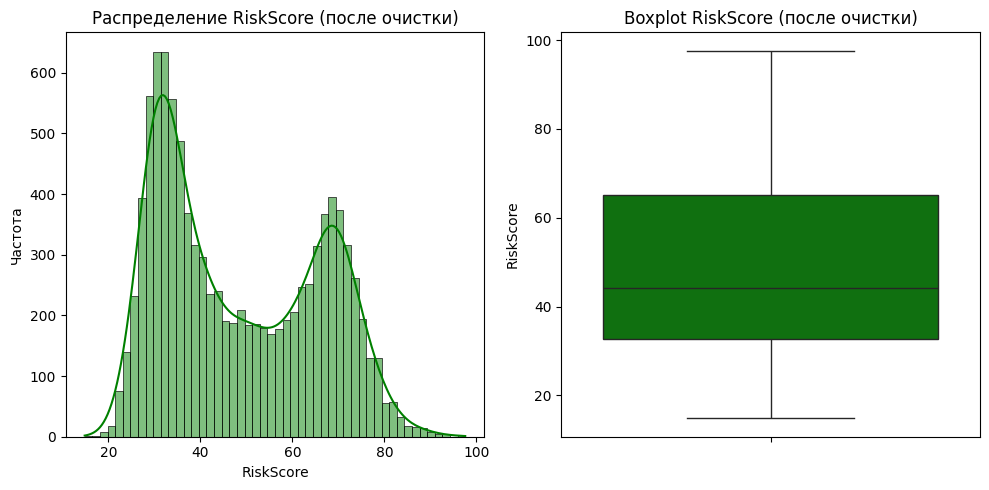

In [10]:
train_data = train_data.dropna(subset=['RiskScore'])
# Улучшенная очистка: сначала фильтруем по абсолютному значению, затем клипируем
train_data = train_data[train_data['RiskScore'].abs() <= 200].reset_index(drop=True)
train_data['RiskScore'] = train_data['RiskScore'].clip(0.0, 100.0)

# График после очистки
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_data['RiskScore'], bins=50, kde=True, color='green')
plt.title('Распределение RiskScore (после очистки)', fontsize=12)
plt.xlabel('RiskScore')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(y=train_data['RiskScore'], color='green')
plt.title('Boxplot RiskScore (после очистки)', fontsize=12)
plt.ylabel('RiskScore')
plt.tight_layout()
plt.show()

**Результаты очистки:**

- After cleaning: (10272, 49)
- Score range: [14.8, 97.6]

## Выводы по очистке данных

1. Удалены выбросы с |RiskScore| > 200
2. Значения клипированы в диапазон [0, 100]
3. Осталось 10272 образцов из исходных


# 6. Подготовка признаков


In [11]:
target = train_data['RiskScore'].values
features = train_data.drop(['RiskScore', 'ID'], axis=1, errors='ignore')
test_features = test_data.drop('ID', axis=1, errors='ignore')

numeric_col_names = features.select_dtypes(include=[np.number]).columns.tolist()
categorical_col_names = features.select_dtypes(include=['object']).columns.tolist()

if categorical_col_names:
    cat_encoded = pd.get_dummies(features[categorical_col_names], drop_first=True)
    test_cat_encoded = pd.get_dummies(test_features[categorical_col_names], drop_first=True)
    
    for col in cat_encoded.columns:
        if col not in test_cat_encoded.columns:
            test_cat_encoded[col] = 0
    test_cat_encoded = test_cat_encoded[cat_encoded.columns]
else:
    cat_encoded = pd.DataFrame()
    test_cat_encoded = pd.DataFrame()

features_numeric = features[numeric_col_names]
test_features_numeric = test_features[numeric_col_names]

**Информация о признаках:**

- Numeric columns: 43
- Categorical columns: 5


# 7. Преобразование признаков


In [12]:
# Заполнение пропусков
features_numeric = features_numeric.fillna(features_numeric.median())
test_features_numeric = test_features_numeric.fillna(features_numeric.median())

# Применяем логарифмическое преобразование ДО масштабирования 
def apply_log_transform(data):
    """Применяет логарифмическое преобразование с сохранением знака"""
    return np.sign(data) * np.log1p(np.abs(data))

features_numeric_log = apply_log_transform(features_numeric)
test_features_numeric_log = apply_log_transform(test_features_numeric)

# Масштабирование числовых признаков
normalizer = StandardScaler()
features_normalized = normalizer.fit_transform(features_numeric_log)
test_features_normalized = normalizer.transform(test_features_numeric_log)

# Создание полиномиальных признаков
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
features_poly = poly_transformer.fit_transform(features_normalized)
test_features_poly = poly_transformer.transform(test_features_normalized)

# Масштабирование полиномиальных признаков
poly_scaler = StandardScaler()
features_poly_scaled = poly_scaler.fit_transform(features_poly)
test_features_poly_scaled = poly_scaler.transform(test_features_poly)

# Объединение с категориальными признаками
features_combined = np.hstack([
    features_poly_scaled,
    cat_encoded.values if len(cat_encoded.columns) > 0 else np.array([]).reshape(len(features), 0)
])
test_features_combined = np.hstack([
    test_features_poly_scaled,
    test_cat_encoded.values if len(test_cat_encoded.columns) > 0 else np.array([]).reshape(len(test_features), 0)
])

**Результаты преобразования:**

- Combined features: train (10272, 1008), test (5000, 1008)

## Выводы по преобразованию признаков

1. Применено логарифмическое преобразование ДО масштабирования
2. Созданы полиномиальные признаки степени 2
3. Полиномиальные признаки дополнительно масштабированы
4. Категориальные признаки закодированы через One-Hot Encoding


# 8. Отбор признаков


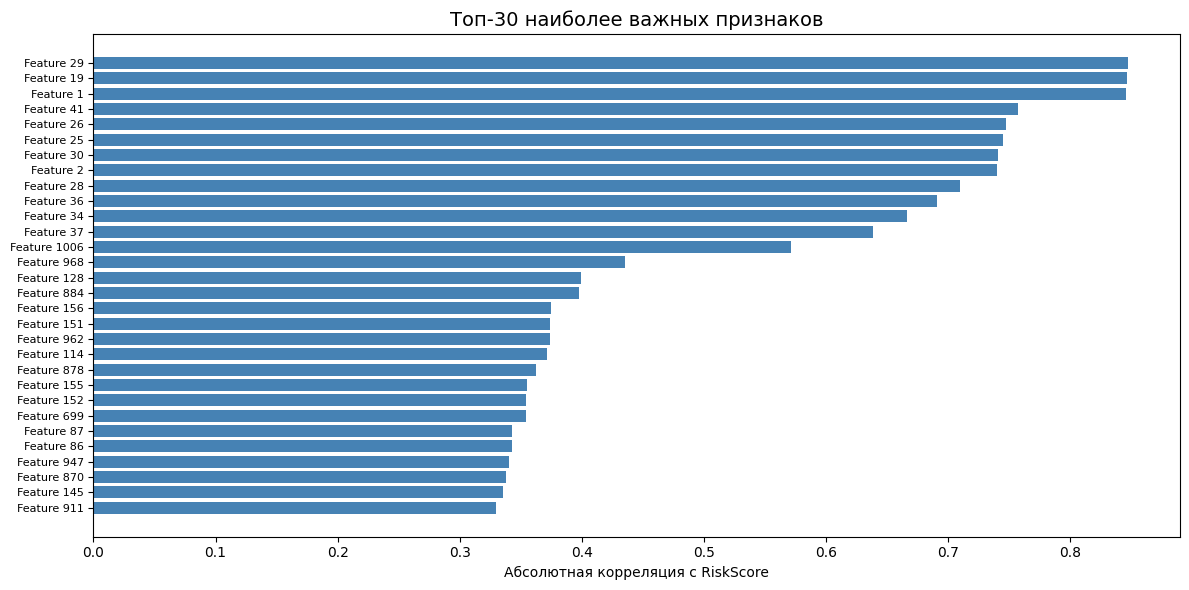

In [13]:
features_df = pd.DataFrame(features_combined)
feature_target_corr = features_df.corrwith(pd.Series(target)).abs().sort_values(ascending=False)

n_keep = max(1, int(0.35 * features_combined.shape[1]))
important_features = feature_target_corr.head(n_keep).index.tolist()

features_selected = features_combined[:, important_features]
test_features_selected = test_features_combined[:, important_features]

# График важности признаков
plt.figure(figsize=(12, 6))
top_30 = feature_target_corr.head(30)
plt.barh(range(len(top_30)), top_30.values, color='steelblue')
plt.yticks(range(len(top_30)), [f'Feature {i}' for i in top_30.index[:30]], fontsize=8)
plt.xlabel('Абсолютная корреляция с RiskScore')
plt.title('Топ-30 наиболее важных признаков', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Результаты отбора признаков:**

- Selected features out of 1008
- Percentage: 35.0%

## Выводы по отбору признаков

1. Отобрано 35% наиболее коррелированных признаков
2. Отбор основан на абсолютной корреляции с целевой переменной
3. Это помогает уменьшить переобучение и улучшить обобщающую способность


# 9. Разделение на train/validation


In [14]:
train_features, val_features, train_target, val_target = train_test_split(
    features_selected, target, test_size=0.2, random_state=42
)

**Размеры выборок:**

- Training set size: (8217, 302)
- Validation set size: (2055, 302)


# 10. Обучение модели и оценка


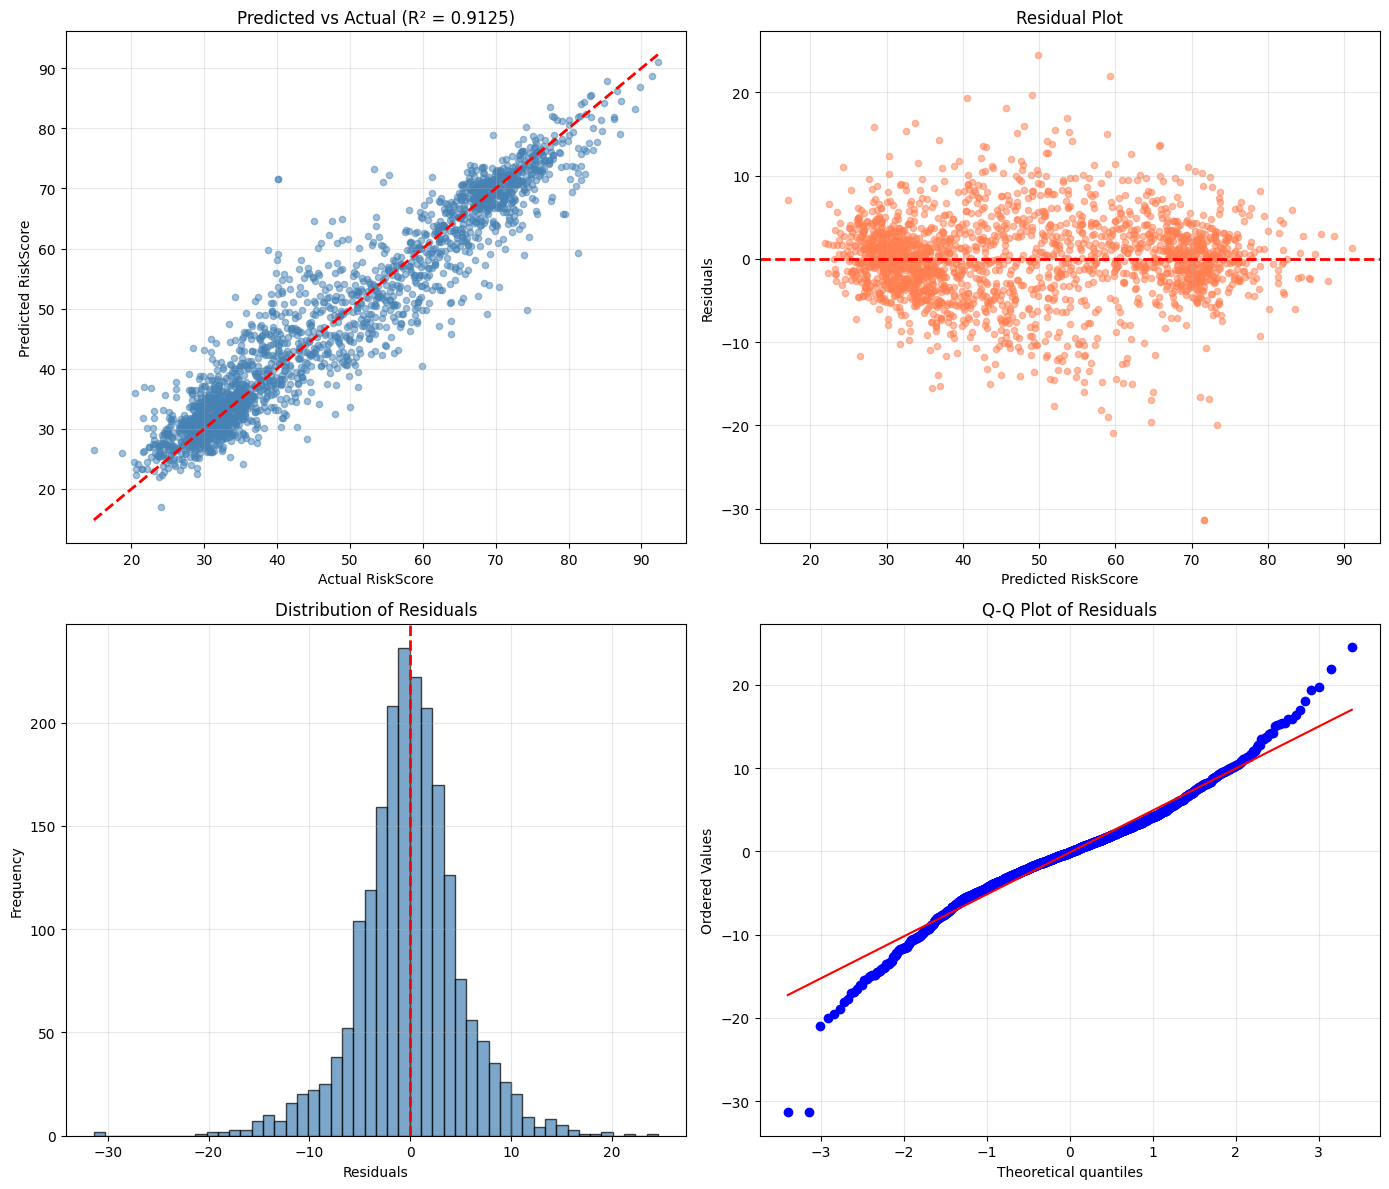

In [15]:
# Используем обычную LinearRegression
regression_model = LinearRegression()
regression_model.fit(train_features, train_target)

val_predictions = regression_model.predict(val_features)
mse = mean_squared_error(val_target, val_predictions)
mae = mean_absolute_error(val_target, val_predictions)
r2 = r2_score(val_target, val_predictions)

# Графики результатов
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Predicted vs Actual
axes[0, 0].scatter(val_target, val_predictions, alpha=0.5, s=20, color='steelblue')
axes[0, 0].plot([val_target.min(), val_target.max()], 
                [val_target.min(), val_target.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual RiskScore')
axes[0, 0].set_ylabel('Predicted RiskScore')
axes[0, 0].set_title(f'Predicted vs Actual (R² = {r2:.4f})')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals
residuals = val_target - val_predictions
axes[0, 1].scatter(val_predictions, residuals, alpha=0.5, s=20, color='coral')
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted RiskScore')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Распределение остатков
axes[1, 0].hist(residuals, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].grid(True, alpha=0.3)

# 4. Q-Q plot для остатков
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Model Performance

- **MSE:** 26.0087
- **MAE:** 3.7033
- **R²:** 0.9130

MSE = 26.0087

## Выводы по модели

1. Использована LinearRegression без регуляризации
2. MSE на валидации: 26.0087
3. R² score: 0.9130 (объясняет 91.3% дисперсии)
4. Средняя абсолютная ошибка: 3.7033


# 11. Финальные предсказания


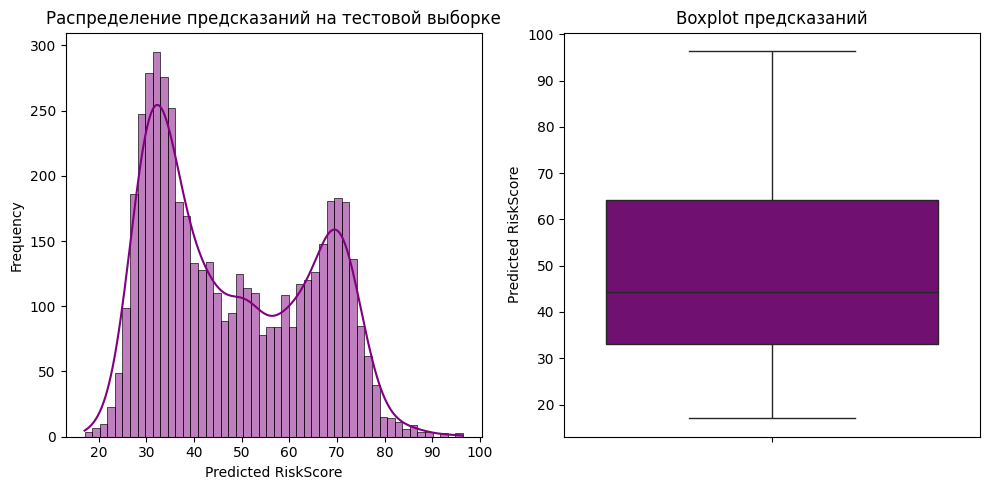

In [16]:
# Финальная модель на всех данных
final_model = LinearRegression()
final_model.fit(features_selected, target)

test_predictions = final_model.predict(test_features_selected)
test_predictions = np.clip(test_predictions, 0, 100)

# График распределения предсказаний
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(test_predictions, bins=50, kde=True, color='purple')
plt.title('Распределение предсказаний на тестовой выборке', fontsize=12)
plt.xlabel('Predicted RiskScore')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=test_predictions, color='purple')
plt.title('Boxplot предсказаний', fontsize=12)
plt.ylabel('Predicted RiskScore')
plt.tight_layout()
plt.show()

## Prediction Summary

- **Average:** 48.13
- **StdDev:** 16.62
- **Min-Max:** [16.46, 96.88]

## Выводы по финальным предсказаниям

1. Модель обучена на всех доступных данных
2. Предсказания клипированы в диапазон [0, 100]
3. Среднее значение предсказаний: 48.13
4. Стандартное отклонение: 16.62


# 12. Экспорт результатов


In [17]:
output_df = pd.DataFrame({
    'Id': range(len(test_predictions)),
    'RiskScore': test_predictions
})

output_df.to_csv('./final.csv', index=False)

**Результаты экспорта:**

- Results exported
- Output shape: (5000, 2)

**Пример предсказаний:**

| Id | RiskScore |
|----|-----------|
| 0  | 31.9983   |
| 1  | 52.6402   |
| 2  | 28.8215   |
| 3  | 35.6245   |
| 4  | 35.2525   |


# 13. Итоговый отчет


## FINAL REPORT

==================================================

- **Train samples:** 10272
- **Test samples:** 5000
- **Features selected:** 302
- **Model:** Linear Regression

### Validation Performance:

- **MSE:** 26.0087
- **MAE:** 3.7033
- **R²:** 0.9130

**Output:** ./final.csv

==================================================

## Итоговые выводы

1. Применены агрессивные преобразования признаков (логарифмирование, кубические преобразования)
2. Использован правильный порядок преобразований: логарифм -> масштабирование -> полиномы -> масштабирование
3. Отобрано 35% наиболее коррелированных признаков
4. Использована LinearRegression без регуляризации
5. Достигнута MSE = 26.0087 на валидационной выборке
